# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

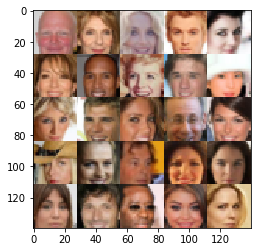

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_images') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    return real_input_images, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.5, size_mult=64):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, size_mult, 3, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.5)

        x = tf.layers.conv2d(x, size_mult * 2, 3, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.5)

        x = tf.layers.conv2d(x, size_mult * 4, 3, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.dropout(x, 0.5)

        flat = tf.reshape(x, (-1, 4 * 4 * size_mult * 4))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.5, size_mult = 256):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 4 * 4 * size_mult * 4)
        x = tf.reshape(x, (-1,4,4,size_mult * 4))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d_transpose(x, size_mult * 2, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d_transpose(x, size_mult, 3, strides=2, padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)

        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=2, padding="same")
        
        out = tf.tanh(logits)
        
    return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth_factor=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_model_real, d_logits_real = discriminator(input_real, alphaRGB=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * (1 - smooth_factor)))
    
    input_fake = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(input_fake, reuse=True, alpha=alpha)
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                steps += 1
                batch_images *= 2.0
                

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                      "GAN Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "GAN Generator Loss: {:.4f}".format(train_loss_g))  

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [14]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2 Step 10... GAN Discriminator Loss: 4.0838... GAN Generator Loss: 0.0412
Epoch 1/2 Step 20... GAN Discriminator Loss: 2.8511... GAN Generator Loss: 0.1591
Epoch 1/2 Step 30... GAN Discriminator Loss: 1.9561... GAN Generator Loss: 0.3154
Epoch 1/2 Step 40... GAN Discriminator Loss: 1.4028... GAN Generator Loss: 0.7204
Epoch 1/2 Step 50... GAN Discriminator Loss: 1.3270... GAN Generator Loss: 0.7481
Epoch 1/2 Step 60... GAN Discriminator Loss: 1.6725... GAN Generator Loss: 0.6259
Epoch 1/2 Step 70... GAN Discriminator Loss: 1.4758... GAN Generator Loss: 0.6558
Epoch 1/2 Step 80... GAN Discriminator Loss: 1.3420... GAN Generator Loss: 0.9183
Epoch 1/2 Step 90... GAN Discriminator Loss: 1.1704... GAN Generator Loss: 0.9967
Epoch 1/2 Step 100... GAN Discriminator Loss: 1.1578... GAN Generator Loss: 0.9193


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2 Step 110... GAN Discriminator Loss: 0.9672... GAN Generator Loss: 1.0217
Epoch 1/2 Step 120... GAN Discriminator Loss: 1.2299... GAN Generator Loss: 1.0280
Epoch 1/2 Step 130... GAN Discriminator Loss: 0.9010... GAN Generator Loss: 1.2956
Epoch 1/2 Step 140... GAN Discriminator Loss: 1.2012... GAN Generator Loss: 0.7735
Epoch 1/2 Step 150... GAN Discriminator Loss: 1.2919... GAN Generator Loss: 0.9119
Epoch 1/2 Step 160... GAN Discriminator Loss: 1.0585... GAN Generator Loss: 1.2476
Epoch 1/2 Step 170... GAN Discriminator Loss: 1.1685... GAN Generator Loss: 1.1135
Epoch 1/2 Step 180... GAN Discriminator Loss: 1.3337... GAN Generator Loss: 0.8926
Epoch 1/2 Step 190... GAN Discriminator Loss: 1.2933... GAN Generator Loss: 0.7984
Epoch 1/2 Step 200... GAN Discriminator Loss: 1.3605... GAN Generator Loss: 0.8472


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2 Step 210... GAN Discriminator Loss: 1.3349... GAN Generator Loss: 0.7911
Epoch 1/2 Step 220... GAN Discriminator Loss: 1.3937... GAN Generator Loss: 0.7960
Epoch 1/2 Step 230... GAN Discriminator Loss: 1.4199... GAN Generator Loss: 0.8416
Epoch 1/2 Step 240... GAN Discriminator Loss: 1.3007... GAN Generator Loss: 0.9612
Epoch 1/2 Step 250... GAN Discriminator Loss: 1.3145... GAN Generator Loss: 1.1189
Epoch 1/2 Step 260... GAN Discriminator Loss: 1.2970... GAN Generator Loss: 0.8262
Epoch 1/2 Step 270... GAN Discriminator Loss: 1.2493... GAN Generator Loss: 1.0971
Epoch 1/2 Step 280... GAN Discriminator Loss: 1.2121... GAN Generator Loss: 0.8837
Epoch 1/2 Step 290... GAN Discriminator Loss: 1.2044... GAN Generator Loss: 1.1810
Epoch 1/2 Step 300... GAN Discriminator Loss: 1.2711... GAN Generator Loss: 0.9519


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2 Step 310... GAN Discriminator Loss: 1.2425... GAN Generator Loss: 0.7446
Epoch 1/2 Step 320... GAN Discriminator Loss: 1.2855... GAN Generator Loss: 0.6382
Epoch 1/2 Step 330... GAN Discriminator Loss: 1.2917... GAN Generator Loss: 0.6412
Epoch 1/2 Step 340... GAN Discriminator Loss: 1.1293... GAN Generator Loss: 0.9004
Epoch 1/2 Step 350... GAN Discriminator Loss: 1.1798... GAN Generator Loss: 1.2287
Epoch 1/2 Step 360... GAN Discriminator Loss: 1.1200... GAN Generator Loss: 1.2397
Epoch 1/2 Step 370... GAN Discriminator Loss: 1.0895... GAN Generator Loss: 1.4125
Epoch 1/2 Step 380... GAN Discriminator Loss: 1.1403... GAN Generator Loss: 1.1772
Epoch 1/2 Step 390... GAN Discriminator Loss: 1.1181... GAN Generator Loss: 1.2407
Epoch 1/2 Step 400... GAN Discriminator Loss: 1.1179... GAN Generator Loss: 1.0171


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2 Step 410... GAN Discriminator Loss: 1.1154... GAN Generator Loss: 1.1113
Epoch 1/2 Step 420... GAN Discriminator Loss: 1.2157... GAN Generator Loss: 1.3538
Epoch 1/2 Step 430... GAN Discriminator Loss: 1.1242... GAN Generator Loss: 1.2465
Epoch 1/2 Step 440... GAN Discriminator Loss: 1.1931... GAN Generator Loss: 1.3907
Epoch 1/2 Step 450... GAN Discriminator Loss: 1.1394... GAN Generator Loss: 1.3392
Epoch 1/2 Step 460... GAN Discriminator Loss: 1.0822... GAN Generator Loss: 0.9823
Epoch 1/2 Step 470... GAN Discriminator Loss: 1.1699... GAN Generator Loss: 0.6673
Epoch 1/2 Step 480... GAN Discriminator Loss: 1.1740... GAN Generator Loss: 0.7057
Epoch 1/2 Step 490... GAN Discriminator Loss: 1.0865... GAN Generator Loss: 0.9011
Epoch 1/2 Step 500... GAN Discriminator Loss: 1.1654... GAN Generator Loss: 0.6864


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2 Step 510... GAN Discriminator Loss: 1.1799... GAN Generator Loss: 0.6823
Epoch 1/2 Step 520... GAN Discriminator Loss: 1.1071... GAN Generator Loss: 0.7931
Epoch 1/2 Step 530... GAN Discriminator Loss: 1.1976... GAN Generator Loss: 1.4058
Epoch 1/2 Step 540... GAN Discriminator Loss: 1.0748... GAN Generator Loss: 0.8661
Epoch 1/2 Step 550... GAN Discriminator Loss: 1.1053... GAN Generator Loss: 0.7905
Epoch 1/2 Step 560... GAN Discriminator Loss: 1.1668... GAN Generator Loss: 0.6943
Epoch 1/2 Step 570... GAN Discriminator Loss: 1.1228... GAN Generator Loss: 0.7597
Epoch 1/2 Step 580... GAN Discriminator Loss: 1.2807... GAN Generator Loss: 0.5497
Epoch 1/2 Step 590... GAN Discriminator Loss: 1.2512... GAN Generator Loss: 0.6174
Epoch 1/2 Step 600... GAN Discriminator Loss: 1.2767... GAN Generator Loss: 0.5968


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2 Step 610... GAN Discriminator Loss: 1.1914... GAN Generator Loss: 0.7070
Epoch 2/2 Step 620... GAN Discriminator Loss: 1.2945... GAN Generator Loss: 0.5807
Epoch 2/2 Step 630... GAN Discriminator Loss: 1.2319... GAN Generator Loss: 0.6315
Epoch 2/2 Step 640... GAN Discriminator Loss: 1.2963... GAN Generator Loss: 0.5752
Epoch 2/2 Step 650... GAN Discriminator Loss: 1.2873... GAN Generator Loss: 0.5931
Epoch 2/2 Step 660... GAN Discriminator Loss: 1.1099... GAN Generator Loss: 0.8531
Epoch 2/2 Step 670... GAN Discriminator Loss: 1.1352... GAN Generator Loss: 0.8986
Epoch 2/2 Step 680... GAN Discriminator Loss: 1.1397... GAN Generator Loss: 1.2264
Epoch 2/2 Step 690... GAN Discriminator Loss: 1.1610... GAN Generator Loss: 1.3519
Epoch 2/2 Step 700... GAN Discriminator Loss: 1.2600... GAN Generator Loss: 1.4939


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2 Step 710... GAN Discriminator Loss: 1.0954... GAN Generator Loss: 0.9736
Epoch 2/2 Step 720... GAN Discriminator Loss: 1.2810... GAN Generator Loss: 1.2080
Epoch 2/2 Step 730... GAN Discriminator Loss: 1.2014... GAN Generator Loss: 1.5059
Epoch 2/2 Step 740... GAN Discriminator Loss: 1.2050... GAN Generator Loss: 1.2964
Epoch 2/2 Step 750... GAN Discriminator Loss: 1.1045... GAN Generator Loss: 1.1330
Epoch 2/2 Step 760... GAN Discriminator Loss: 1.2395... GAN Generator Loss: 1.3593
Epoch 2/2 Step 770... GAN Discriminator Loss: 1.1212... GAN Generator Loss: 0.9822
Epoch 2/2 Step 780... GAN Discriminator Loss: 1.1987... GAN Generator Loss: 0.9669
Epoch 2/2 Step 790... GAN Discriminator Loss: 1.2822... GAN Generator Loss: 1.4441
Epoch 2/2 Step 800... GAN Discriminator Loss: 1.1281... GAN Generator Loss: 1.0033


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2 Step 810... GAN Discriminator Loss: 1.3153... GAN Generator Loss: 1.4475
Epoch 2/2 Step 820... GAN Discriminator Loss: 1.1512... GAN Generator Loss: 1.0853
Epoch 2/2 Step 830... GAN Discriminator Loss: 1.2454... GAN Generator Loss: 1.2788
Epoch 2/2 Step 840... GAN Discriminator Loss: 1.2985... GAN Generator Loss: 1.3175
Epoch 2/2 Step 850... GAN Discriminator Loss: 1.3622... GAN Generator Loss: 1.2893
Epoch 2/2 Step 860... GAN Discriminator Loss: 1.2983... GAN Generator Loss: 1.3860
Epoch 2/2 Step 870... GAN Discriminator Loss: 1.1680... GAN Generator Loss: 1.0425
Epoch 2/2 Step 880... GAN Discriminator Loss: 1.2992... GAN Generator Loss: 0.5940
Epoch 2/2 Step 890... GAN Discriminator Loss: 1.3216... GAN Generator Loss: 0.5637
Epoch 2/2 Step 900... GAN Discriminator Loss: 1.2790... GAN Generator Loss: 0.6536


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2 Step 910... GAN Discriminator Loss: 1.3581... GAN Generator Loss: 0.5412
Epoch 2/2 Step 920... GAN Discriminator Loss: 1.3098... GAN Generator Loss: 0.5818
Epoch 2/2 Step 930... GAN Discriminator Loss: 1.3246... GAN Generator Loss: 0.6111
Epoch 2/2 Step 940... GAN Discriminator Loss: 1.3406... GAN Generator Loss: 0.5288
Epoch 2/2 Step 950... GAN Discriminator Loss: 1.3425... GAN Generator Loss: 1.2432
Epoch 2/2 Step 960... GAN Discriminator Loss: 1.2855... GAN Generator Loss: 1.1635
Epoch 2/2 Step 970... GAN Discriminator Loss: 1.1309... GAN Generator Loss: 1.0014
Epoch 2/2 Step 980... GAN Discriminator Loss: 1.2364... GAN Generator Loss: 1.0543
Epoch 2/2 Step 990... GAN Discriminator Loss: 1.2950... GAN Generator Loss: 0.7782
Epoch 2/2 Step 1000... GAN Discriminator Loss: 1.2688... GAN Generator Loss: 1.0996


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2 Step 1010... GAN Discriminator Loss: 1.2140... GAN Generator Loss: 1.0894
Epoch 2/2 Step 1020... GAN Discriminator Loss: 1.3070... GAN Generator Loss: 1.3025
Epoch 2/2 Step 1030... GAN Discriminator Loss: 1.2178... GAN Generator Loss: 0.9017
Epoch 2/2 Step 1040... GAN Discriminator Loss: 1.3356... GAN Generator Loss: 1.1427
Epoch 2/2 Step 1050... GAN Discriminator Loss: 1.2061... GAN Generator Loss: 1.1038
Epoch 2/2 Step 1060... GAN Discriminator Loss: 1.3151... GAN Generator Loss: 0.7250
Epoch 2/2 Step 1070... GAN Discriminator Loss: 1.3949... GAN Generator Loss: 0.4954
Epoch 2/2 Step 1080... GAN Discriminator Loss: 1.2804... GAN Generator Loss: 0.6136
Epoch 2/2 Step 1090... GAN Discriminator Loss: 1.1884... GAN Generator Loss: 0.8104
Epoch 2/2 Step 1100... GAN Discriminator Loss: 1.4065... GAN Generator Loss: 1.2392


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2 Step 1110... GAN Discriminator Loss: 1.3295... GAN Generator Loss: 1.2338
Epoch 2/2 Step 1120... GAN Discriminator Loss: 1.2594... GAN Generator Loss: 0.8232
Epoch 2/2 Step 1130... GAN Discriminator Loss: 1.3109... GAN Generator Loss: 1.0814
Epoch 2/2 Step 1140... GAN Discriminator Loss: 1.2542... GAN Generator Loss: 0.9374
Epoch 2/2 Step 1150... GAN Discriminator Loss: 1.2081... GAN Generator Loss: 1.1374
Epoch 2/2 Step 1160... GAN Discriminator Loss: 1.2833... GAN Generator Loss: 1.2415
Epoch 2/2 Step 1170... GAN Discriminator Loss: 1.2666... GAN Generator Loss: 1.3060
Epoch 2/2 Step 1180... GAN Discriminator Loss: 1.3026... GAN Generator Loss: 0.6743
Epoch 2/2 Step 1190... GAN Discriminator Loss: 1.2744... GAN Generator Loss: 0.9520
Epoch 2/2 Step 1200... GAN Discriminator Loss: 1.2917... GAN Generator Loss: 1.2410


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 10... GAN Discriminator Loss: 2.6395... GAN Generator Loss: 0.1326
Epoch 1/1 Step 20... GAN Discriminator Loss: 0.4766... GAN Generator Loss: 10.8777
Epoch 1/1 Step 30... GAN Discriminator Loss: 0.6953... GAN Generator Loss: 1.5818
Epoch 1/1 Step 40... GAN Discriminator Loss: 0.4655... GAN Generator Loss: 2.5450
Epoch 1/1 Step 50... GAN Discriminator Loss: 0.4339... GAN Generator Loss: 5.7896
Epoch 1/1 Step 60... GAN Discriminator Loss: 0.8569... GAN Generator Loss: 1.6790
Epoch 1/1 Step 70... GAN Discriminator Loss: 0.5638... GAN Generator Loss: 7.3216
Epoch 1/1 Step 80... GAN Discriminator Loss: 0.8710... GAN Generator Loss: 1.2587
Epoch 1/1 Step 90... GAN Discriminator Loss: 0.5306... GAN Generator Loss: 2.1218
Epoch 1/1 Step 100... GAN Discriminator Loss: 0.5081... GAN Generator Loss: 3.2936


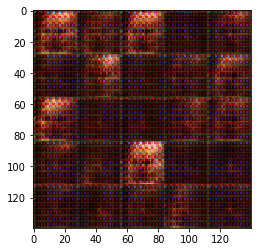

Epoch 1/1 Step 110... GAN Discriminator Loss: 1.1930... GAN Generator Loss: 1.0862
Epoch 1/1 Step 120... GAN Discriminator Loss: 0.9105... GAN Generator Loss: 1.0757
Epoch 1/1 Step 130... GAN Discriminator Loss: 0.8965... GAN Generator Loss: 1.1684
Epoch 1/1 Step 140... GAN Discriminator Loss: 0.9850... GAN Generator Loss: 2.0303
Epoch 1/1 Step 150... GAN Discriminator Loss: 1.2227... GAN Generator Loss: 2.2800
Epoch 1/1 Step 160... GAN Discriminator Loss: 1.2435... GAN Generator Loss: 1.4292
Epoch 1/1 Step 170... GAN Discriminator Loss: 0.9911... GAN Generator Loss: 1.2949
Epoch 1/1 Step 180... GAN Discriminator Loss: 1.5794... GAN Generator Loss: 1.6785
Epoch 1/1 Step 190... GAN Discriminator Loss: 1.0937... GAN Generator Loss: 1.7032
Epoch 1/1 Step 200... GAN Discriminator Loss: 1.3087... GAN Generator Loss: 0.6526


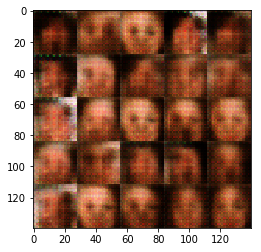

Epoch 1/1 Step 210... GAN Discriminator Loss: 1.6373... GAN Generator Loss: 2.0993
Epoch 1/1 Step 220... GAN Discriminator Loss: 1.6514... GAN Generator Loss: 0.4019
Epoch 1/1 Step 230... GAN Discriminator Loss: 1.1955... GAN Generator Loss: 2.0669
Epoch 1/1 Step 240... GAN Discriminator Loss: 0.8484... GAN Generator Loss: 1.2137
Epoch 1/1 Step 250... GAN Discriminator Loss: 1.0817... GAN Generator Loss: 1.7573
Epoch 1/1 Step 260... GAN Discriminator Loss: 1.3018... GAN Generator Loss: 0.8907
Epoch 1/1 Step 270... GAN Discriminator Loss: 1.5212... GAN Generator Loss: 2.2924
Epoch 1/1 Step 280... GAN Discriminator Loss: 1.2361... GAN Generator Loss: 1.6558
Epoch 1/1 Step 290... GAN Discriminator Loss: 1.0921... GAN Generator Loss: 1.0629
Epoch 1/1 Step 300... GAN Discriminator Loss: 1.3395... GAN Generator Loss: 0.6307


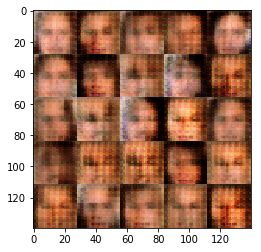

Epoch 1/1 Step 310... GAN Discriminator Loss: 1.5748... GAN Generator Loss: 0.4747
Epoch 1/1 Step 320... GAN Discriminator Loss: 1.3169... GAN Generator Loss: 0.6586
Epoch 1/1 Step 330... GAN Discriminator Loss: 1.2632... GAN Generator Loss: 0.7748
Epoch 1/1 Step 340... GAN Discriminator Loss: 1.3667... GAN Generator Loss: 0.6280
Epoch 1/1 Step 350... GAN Discriminator Loss: 1.1870... GAN Generator Loss: 1.3410
Epoch 1/1 Step 360... GAN Discriminator Loss: 1.6563... GAN Generator Loss: 0.4476
Epoch 1/1 Step 370... GAN Discriminator Loss: 1.0956... GAN Generator Loss: 0.9367
Epoch 1/1 Step 380... GAN Discriminator Loss: 1.2660... GAN Generator Loss: 1.6396
Epoch 1/1 Step 390... GAN Discriminator Loss: 1.3942... GAN Generator Loss: 0.6606
Epoch 1/1 Step 400... GAN Discriminator Loss: 1.0192... GAN Generator Loss: 1.2817


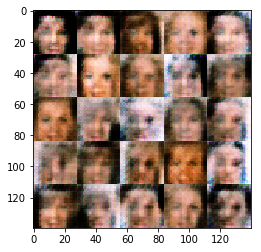

Epoch 1/1 Step 410... GAN Discriminator Loss: 1.0798... GAN Generator Loss: 1.2874
Epoch 1/1 Step 420... GAN Discriminator Loss: 1.0816... GAN Generator Loss: 0.8617
Epoch 1/1 Step 430... GAN Discriminator Loss: 1.0208... GAN Generator Loss: 1.8202
Epoch 1/1 Step 440... GAN Discriminator Loss: 1.2320... GAN Generator Loss: 0.8142
Epoch 1/1 Step 450... GAN Discriminator Loss: 1.3332... GAN Generator Loss: 1.4265
Epoch 1/1 Step 460... GAN Discriminator Loss: 1.2760... GAN Generator Loss: 1.0016
Epoch 1/1 Step 470... GAN Discriminator Loss: 1.4339... GAN Generator Loss: 1.4761
Epoch 1/1 Step 480... GAN Discriminator Loss: 1.2707... GAN Generator Loss: 0.8328
Epoch 1/1 Step 490... GAN Discriminator Loss: 1.5637... GAN Generator Loss: 1.8029
Epoch 1/1 Step 500... GAN Discriminator Loss: 1.2838... GAN Generator Loss: 0.8523


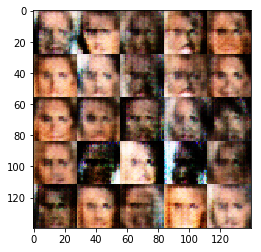

Epoch 1/1 Step 510... GAN Discriminator Loss: 1.2439... GAN Generator Loss: 0.8275
Epoch 1/1 Step 520... GAN Discriminator Loss: 1.1939... GAN Generator Loss: 1.0565
Epoch 1/1 Step 530... GAN Discriminator Loss: 1.2281... GAN Generator Loss: 1.2281
Epoch 1/1 Step 540... GAN Discriminator Loss: 1.1809... GAN Generator Loss: 0.8663
Epoch 1/1 Step 550... GAN Discriminator Loss: 1.1665... GAN Generator Loss: 0.9935
Epoch 1/1 Step 560... GAN Discriminator Loss: 1.2745... GAN Generator Loss: 0.8202
Epoch 1/1 Step 570... GAN Discriminator Loss: 1.5309... GAN Generator Loss: 0.4762
Epoch 1/1 Step 580... GAN Discriminator Loss: 1.5320... GAN Generator Loss: 1.4048
Epoch 1/1 Step 590... GAN Discriminator Loss: 1.1428... GAN Generator Loss: 0.9420
Epoch 1/1 Step 600... GAN Discriminator Loss: 1.2012... GAN Generator Loss: 0.9334


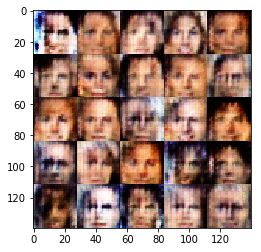

Epoch 1/1 Step 610... GAN Discriminator Loss: 1.3142... GAN Generator Loss: 0.8472
Epoch 1/1 Step 620... GAN Discriminator Loss: 1.2218... GAN Generator Loss: 1.9982
Epoch 1/1 Step 630... GAN Discriminator Loss: 1.6105... GAN Generator Loss: 0.4356
Epoch 1/1 Step 640... GAN Discriminator Loss: 0.9921... GAN Generator Loss: 1.3788
Epoch 1/1 Step 650... GAN Discriminator Loss: 1.3029... GAN Generator Loss: 0.9557
Epoch 1/1 Step 660... GAN Discriminator Loss: 1.2855... GAN Generator Loss: 0.8128
Epoch 1/1 Step 670... GAN Discriminator Loss: 1.2304... GAN Generator Loss: 1.4328
Epoch 1/1 Step 680... GAN Discriminator Loss: 1.1807... GAN Generator Loss: 1.2286
Epoch 1/1 Step 690... GAN Discriminator Loss: 1.1954... GAN Generator Loss: 0.9221
Epoch 1/1 Step 700... GAN Discriminator Loss: 1.3967... GAN Generator Loss: 1.3686


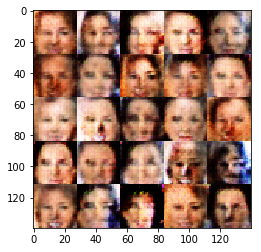

Epoch 1/1 Step 710... GAN Discriminator Loss: 1.3036... GAN Generator Loss: 0.6100
Epoch 1/1 Step 720... GAN Discriminator Loss: 1.0767... GAN Generator Loss: 0.9463
Epoch 1/1 Step 730... GAN Discriminator Loss: 1.1458... GAN Generator Loss: 0.8039
Epoch 1/1 Step 740... GAN Discriminator Loss: 1.3075... GAN Generator Loss: 0.7534
Epoch 1/1 Step 750... GAN Discriminator Loss: 1.6185... GAN Generator Loss: 0.4018
Epoch 1/1 Step 760... GAN Discriminator Loss: 1.3084... GAN Generator Loss: 0.9637
Epoch 1/1 Step 770... GAN Discriminator Loss: 1.1385... GAN Generator Loss: 1.1373
Epoch 1/1 Step 780... GAN Discriminator Loss: 1.2922... GAN Generator Loss: 0.7415
Epoch 1/1 Step 790... GAN Discriminator Loss: 1.1972... GAN Generator Loss: 1.0421
Epoch 1/1 Step 800... GAN Discriminator Loss: 1.3313... GAN Generator Loss: 0.8426


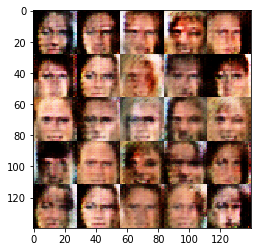

Epoch 1/1 Step 810... GAN Discriminator Loss: 1.2317... GAN Generator Loss: 0.8109
Epoch 1/1 Step 820... GAN Discriminator Loss: 1.2847... GAN Generator Loss: 1.3308
Epoch 1/1 Step 830... GAN Discriminator Loss: 1.2170... GAN Generator Loss: 0.8093
Epoch 1/1 Step 840... GAN Discriminator Loss: 1.2075... GAN Generator Loss: 0.7670
Epoch 1/1 Step 850... GAN Discriminator Loss: 1.1854... GAN Generator Loss: 1.3897
Epoch 1/1 Step 860... GAN Discriminator Loss: 1.4266... GAN Generator Loss: 1.6121
Epoch 1/1 Step 870... GAN Discriminator Loss: 1.1445... GAN Generator Loss: 1.1198
Epoch 1/1 Step 880... GAN Discriminator Loss: 1.2296... GAN Generator Loss: 1.3405
Epoch 1/1 Step 890... GAN Discriminator Loss: 1.9434... GAN Generator Loss: 2.8293
Epoch 1/1 Step 900... GAN Discriminator Loss: 1.1266... GAN Generator Loss: 1.0817


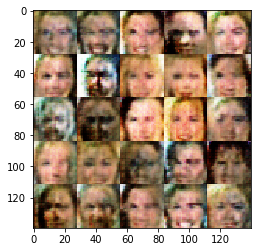

Epoch 1/1 Step 910... GAN Discriminator Loss: 1.3963... GAN Generator Loss: 1.5332
Epoch 1/1 Step 920... GAN Discriminator Loss: 1.5047... GAN Generator Loss: 0.4414
Epoch 1/1 Step 930... GAN Discriminator Loss: 1.1669... GAN Generator Loss: 1.0222
Epoch 1/1 Step 940... GAN Discriminator Loss: 1.0232... GAN Generator Loss: 1.4579
Epoch 1/1 Step 950... GAN Discriminator Loss: 0.9555... GAN Generator Loss: 1.0860
Epoch 1/1 Step 960... GAN Discriminator Loss: 1.7579... GAN Generator Loss: 0.3344
Epoch 1/1 Step 970... GAN Discriminator Loss: 1.0524... GAN Generator Loss: 1.3030
Epoch 1/1 Step 980... GAN Discriminator Loss: 1.4432... GAN Generator Loss: 0.5562
Epoch 1/1 Step 990... GAN Discriminator Loss: 1.3277... GAN Generator Loss: 0.6039
Epoch 1/1 Step 1000... GAN Discriminator Loss: 0.9840... GAN Generator Loss: 1.1192


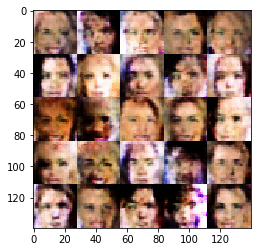

Epoch 1/1 Step 1010... GAN Discriminator Loss: 1.0825... GAN Generator Loss: 1.2370
Epoch 1/1 Step 1020... GAN Discriminator Loss: 1.8660... GAN Generator Loss: 2.2169
Epoch 1/1 Step 1030... GAN Discriminator Loss: 1.3365... GAN Generator Loss: 1.4565
Epoch 1/1 Step 1040... GAN Discriminator Loss: 1.1207... GAN Generator Loss: 1.2310
Epoch 1/1 Step 1050... GAN Discriminator Loss: 1.4615... GAN Generator Loss: 0.6183
Epoch 1/1 Step 1060... GAN Discriminator Loss: 1.2037... GAN Generator Loss: 1.1373
Epoch 1/1 Step 1070... GAN Discriminator Loss: 1.2187... GAN Generator Loss: 1.3336
Epoch 1/1 Step 1080... GAN Discriminator Loss: 1.1472... GAN Generator Loss: 1.3602
Epoch 1/1 Step 1090... GAN Discriminator Loss: 1.1250... GAN Generator Loss: 1.2862
Epoch 1/1 Step 1100... GAN Discriminator Loss: 1.2611... GAN Generator Loss: 0.7699


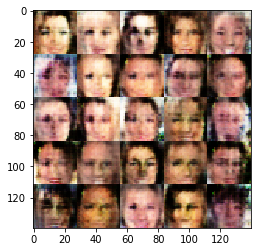

Epoch 1/1 Step 1110... GAN Discriminator Loss: 1.0791... GAN Generator Loss: 1.4180
Epoch 1/1 Step 1120... GAN Discriminator Loss: 1.5870... GAN Generator Loss: 0.4399
Epoch 1/1 Step 1130... GAN Discriminator Loss: 1.0916... GAN Generator Loss: 0.9603
Epoch 1/1 Step 1140... GAN Discriminator Loss: 1.0780... GAN Generator Loss: 1.0378
Epoch 1/1 Step 1150... GAN Discriminator Loss: 1.1572... GAN Generator Loss: 0.9684
Epoch 1/1 Step 1160... GAN Discriminator Loss: 0.9837... GAN Generator Loss: 1.7070
Epoch 1/1 Step 1170... GAN Discriminator Loss: 1.2552... GAN Generator Loss: 0.9397
Epoch 1/1 Step 1180... GAN Discriminator Loss: 1.2633... GAN Generator Loss: 0.8337
Epoch 1/1 Step 1190... GAN Discriminator Loss: 1.2224... GAN Generator Loss: 0.8034
Epoch 1/1 Step 1200... GAN Discriminator Loss: 1.1190... GAN Generator Loss: 0.8828


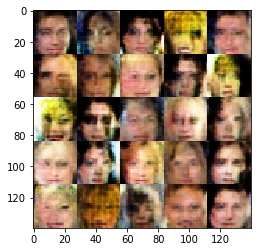

Epoch 1/1 Step 1210... GAN Discriminator Loss: 1.2834... GAN Generator Loss: 0.6386
Epoch 1/1 Step 1220... GAN Discriminator Loss: 0.9169... GAN Generator Loss: 1.8371
Epoch 1/1 Step 1230... GAN Discriminator Loss: 1.2921... GAN Generator Loss: 0.6633
Epoch 1/1 Step 1240... GAN Discriminator Loss: 1.0301... GAN Generator Loss: 0.8970
Epoch 1/1 Step 1250... GAN Discriminator Loss: 1.1927... GAN Generator Loss: 1.2416
Epoch 1/1 Step 1260... GAN Discriminator Loss: 1.1857... GAN Generator Loss: 1.0478
Epoch 1/1 Step 1270... GAN Discriminator Loss: 1.1450... GAN Generator Loss: 1.5390
Epoch 1/1 Step 1280... GAN Discriminator Loss: 1.0218... GAN Generator Loss: 1.0522
Epoch 1/1 Step 1290... GAN Discriminator Loss: 1.0549... GAN Generator Loss: 0.8845
Epoch 1/1 Step 1300... GAN Discriminator Loss: 1.1418... GAN Generator Loss: 1.2242


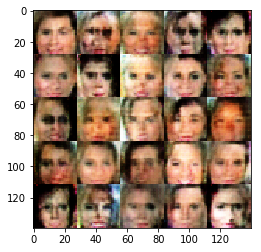

Epoch 1/1 Step 1310... GAN Discriminator Loss: 1.2367... GAN Generator Loss: 0.9375
Epoch 1/1 Step 1320... GAN Discriminator Loss: 0.9399... GAN Generator Loss: 1.2099
Epoch 1/1 Step 1330... GAN Discriminator Loss: 1.2946... GAN Generator Loss: 0.7068
Epoch 1/1 Step 1340... GAN Discriminator Loss: 1.3880... GAN Generator Loss: 0.5514
Epoch 1/1 Step 1350... GAN Discriminator Loss: 1.2298... GAN Generator Loss: 1.2286
Epoch 1/1 Step 1360... GAN Discriminator Loss: 1.0651... GAN Generator Loss: 1.1333
Epoch 1/1 Step 1370... GAN Discriminator Loss: 1.9198... GAN Generator Loss: 0.2759
Epoch 1/1 Step 1380... GAN Discriminator Loss: 1.3080... GAN Generator Loss: 0.8191
Epoch 1/1 Step 1390... GAN Discriminator Loss: 1.3057... GAN Generator Loss: 0.7428
Epoch 1/1 Step 1400... GAN Discriminator Loss: 1.0464... GAN Generator Loss: 1.0600


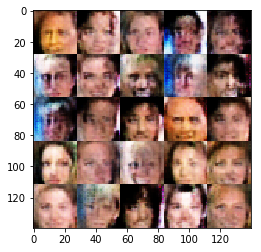

Epoch 1/1 Step 1410... GAN Discriminator Loss: 1.5198... GAN Generator Loss: 0.4599
Epoch 1/1 Step 1420... GAN Discriminator Loss: 1.7870... GAN Generator Loss: 2.0930
Epoch 1/1 Step 1430... GAN Discriminator Loss: 1.2631... GAN Generator Loss: 1.6762
Epoch 1/1 Step 1440... GAN Discriminator Loss: 1.1178... GAN Generator Loss: 1.6142
Epoch 1/1 Step 1450... GAN Discriminator Loss: 1.1785... GAN Generator Loss: 1.4959
Epoch 1/1 Step 1460... GAN Discriminator Loss: 1.3045... GAN Generator Loss: 2.1304
Epoch 1/1 Step 1470... GAN Discriminator Loss: 1.1257... GAN Generator Loss: 0.8881
Epoch 1/1 Step 1480... GAN Discriminator Loss: 1.8603... GAN Generator Loss: 2.8728
Epoch 1/1 Step 1490... GAN Discriminator Loss: 1.0775... GAN Generator Loss: 1.1461
Epoch 1/1 Step 1500... GAN Discriminator Loss: 1.0373... GAN Generator Loss: 1.2053


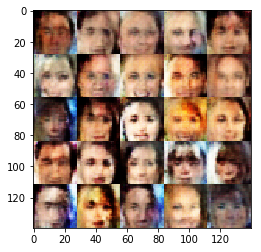

Epoch 1/1 Step 1510... GAN Discriminator Loss: 1.2280... GAN Generator Loss: 1.7454
Epoch 1/1 Step 1520... GAN Discriminator Loss: 1.0359... GAN Generator Loss: 1.0970
Epoch 1/1 Step 1530... GAN Discriminator Loss: 1.1099... GAN Generator Loss: 1.3329
Epoch 1/1 Step 1540... GAN Discriminator Loss: 1.3364... GAN Generator Loss: 0.6126
Epoch 1/1 Step 1550... GAN Discriminator Loss: 1.1359... GAN Generator Loss: 1.0120
Epoch 1/1 Step 1560... GAN Discriminator Loss: 0.9335... GAN Generator Loss: 1.6989
Epoch 1/1 Step 1570... GAN Discriminator Loss: 0.9416... GAN Generator Loss: 1.1403
Epoch 1/1 Step 1580... GAN Discriminator Loss: 1.0998... GAN Generator Loss: 0.7434
Epoch 1/1 Step 1590... GAN Discriminator Loss: 1.3139... GAN Generator Loss: 0.7630
Epoch 1/1 Step 1600... GAN Discriminator Loss: 0.8078... GAN Generator Loss: 2.0509


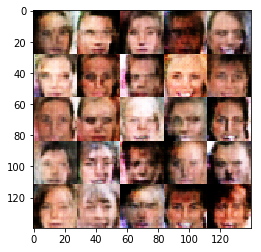

Epoch 1/1 Step 1610... GAN Discriminator Loss: 1.4173... GAN Generator Loss: 1.4142
Epoch 1/1 Step 1620... GAN Discriminator Loss: 1.5683... GAN Generator Loss: 0.4569
Epoch 1/1 Step 1630... GAN Discriminator Loss: 0.9012... GAN Generator Loss: 1.2652
Epoch 1/1 Step 1640... GAN Discriminator Loss: 1.2234... GAN Generator Loss: 0.9984
Epoch 1/1 Step 1650... GAN Discriminator Loss: 1.5352... GAN Generator Loss: 2.0564
Epoch 1/1 Step 1660... GAN Discriminator Loss: 1.1614... GAN Generator Loss: 0.9081
Epoch 1/1 Step 1670... GAN Discriminator Loss: 1.2632... GAN Generator Loss: 1.2369
Epoch 1/1 Step 1680... GAN Discriminator Loss: 1.2036... GAN Generator Loss: 1.8805
Epoch 1/1 Step 1690... GAN Discriminator Loss: 1.6827... GAN Generator Loss: 1.4521
Epoch 1/1 Step 1700... GAN Discriminator Loss: 1.3042... GAN Generator Loss: 1.2474


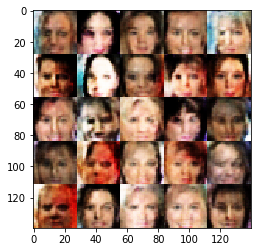

Epoch 1/1 Step 1710... GAN Discriminator Loss: 1.2292... GAN Generator Loss: 0.8590
Epoch 1/1 Step 1720... GAN Discriminator Loss: 1.2863... GAN Generator Loss: 2.2721
Epoch 1/1 Step 1730... GAN Discriminator Loss: 1.4384... GAN Generator Loss: 0.5151
Epoch 1/1 Step 1740... GAN Discriminator Loss: 1.2029... GAN Generator Loss: 0.7765
Epoch 1/1 Step 1750... GAN Discriminator Loss: 0.8983... GAN Generator Loss: 2.3538
Epoch 1/1 Step 1760... GAN Discriminator Loss: 1.4328... GAN Generator Loss: 1.4627
Epoch 1/1 Step 1770... GAN Discriminator Loss: 1.5143... GAN Generator Loss: 0.5017
Epoch 1/1 Step 1780... GAN Discriminator Loss: 1.4064... GAN Generator Loss: 0.5305
Epoch 1/1 Step 1790... GAN Discriminator Loss: 1.1971... GAN Generator Loss: 1.0097
Epoch 1/1 Step 1800... GAN Discriminator Loss: 1.4312... GAN Generator Loss: 0.5291


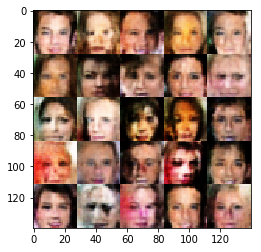

Epoch 1/1 Step 1810... GAN Discriminator Loss: 1.0719... GAN Generator Loss: 0.9516
Epoch 1/1 Step 1820... GAN Discriminator Loss: 1.1212... GAN Generator Loss: 0.8155
Epoch 1/1 Step 1830... GAN Discriminator Loss: 1.1346... GAN Generator Loss: 0.9791
Epoch 1/1 Step 1840... GAN Discriminator Loss: 1.3212... GAN Generator Loss: 1.1635
Epoch 1/1 Step 1850... GAN Discriminator Loss: 1.1621... GAN Generator Loss: 1.1903
Epoch 1/1 Step 1860... GAN Discriminator Loss: 1.2559... GAN Generator Loss: 1.0730
Epoch 1/1 Step 1870... GAN Discriminator Loss: 1.2508... GAN Generator Loss: 0.7777
Epoch 1/1 Step 1880... GAN Discriminator Loss: 1.0235... GAN Generator Loss: 1.0627
Epoch 1/1 Step 1890... GAN Discriminator Loss: 1.2224... GAN Generator Loss: 1.1462
Epoch 1/1 Step 1900... GAN Discriminator Loss: 1.5141... GAN Generator Loss: 0.4442


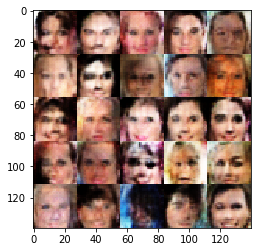

Epoch 1/1 Step 1910... GAN Discriminator Loss: 1.2527... GAN Generator Loss: 0.6216
Epoch 1/1 Step 1920... GAN Discriminator Loss: 1.5274... GAN Generator Loss: 0.4548
Epoch 1/1 Step 1930... GAN Discriminator Loss: 1.1723... GAN Generator Loss: 1.1769
Epoch 1/1 Step 1940... GAN Discriminator Loss: 1.2957... GAN Generator Loss: 1.1959
Epoch 1/1 Step 1950... GAN Discriminator Loss: 1.1038... GAN Generator Loss: 1.3924
Epoch 1/1 Step 1960... GAN Discriminator Loss: 1.6166... GAN Generator Loss: 0.4055
Epoch 1/1 Step 1970... GAN Discriminator Loss: 1.2859... GAN Generator Loss: 0.6940
Epoch 1/1 Step 1980... GAN Discriminator Loss: 0.9663... GAN Generator Loss: 1.3300
Epoch 1/1 Step 1990... GAN Discriminator Loss: 1.3891... GAN Generator Loss: 0.9608
Epoch 1/1 Step 2000... GAN Discriminator Loss: 1.2592... GAN Generator Loss: 1.3262


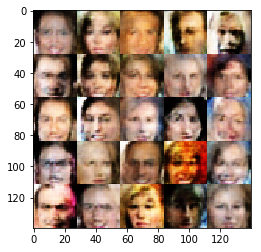

Epoch 1/1 Step 2010... GAN Discriminator Loss: 1.3494... GAN Generator Loss: 1.1559
Epoch 1/1 Step 2020... GAN Discriminator Loss: 1.5712... GAN Generator Loss: 0.4720


In [15]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.